In [1]:
import pandas as pd
import seaborn as sns

## Read the data

In [2]:
seed_data = pd.read_csv("/kaggle/input/seed-from-uci/Seed_Data.csv")

### Rename the column

In [3]:
seed_data.rename(columns={"A":"area","P":"perimeter","C":"compactness",
                 "LK":"length of kernel","WK":"width of kernel",
                 "A_Coef":"asymmetry coefficient",
                 "LKG":"length of kernel groove"},inplace = True)

In [4]:
seed_data.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,target
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


### Check the pair plot as part of Exploratory data analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

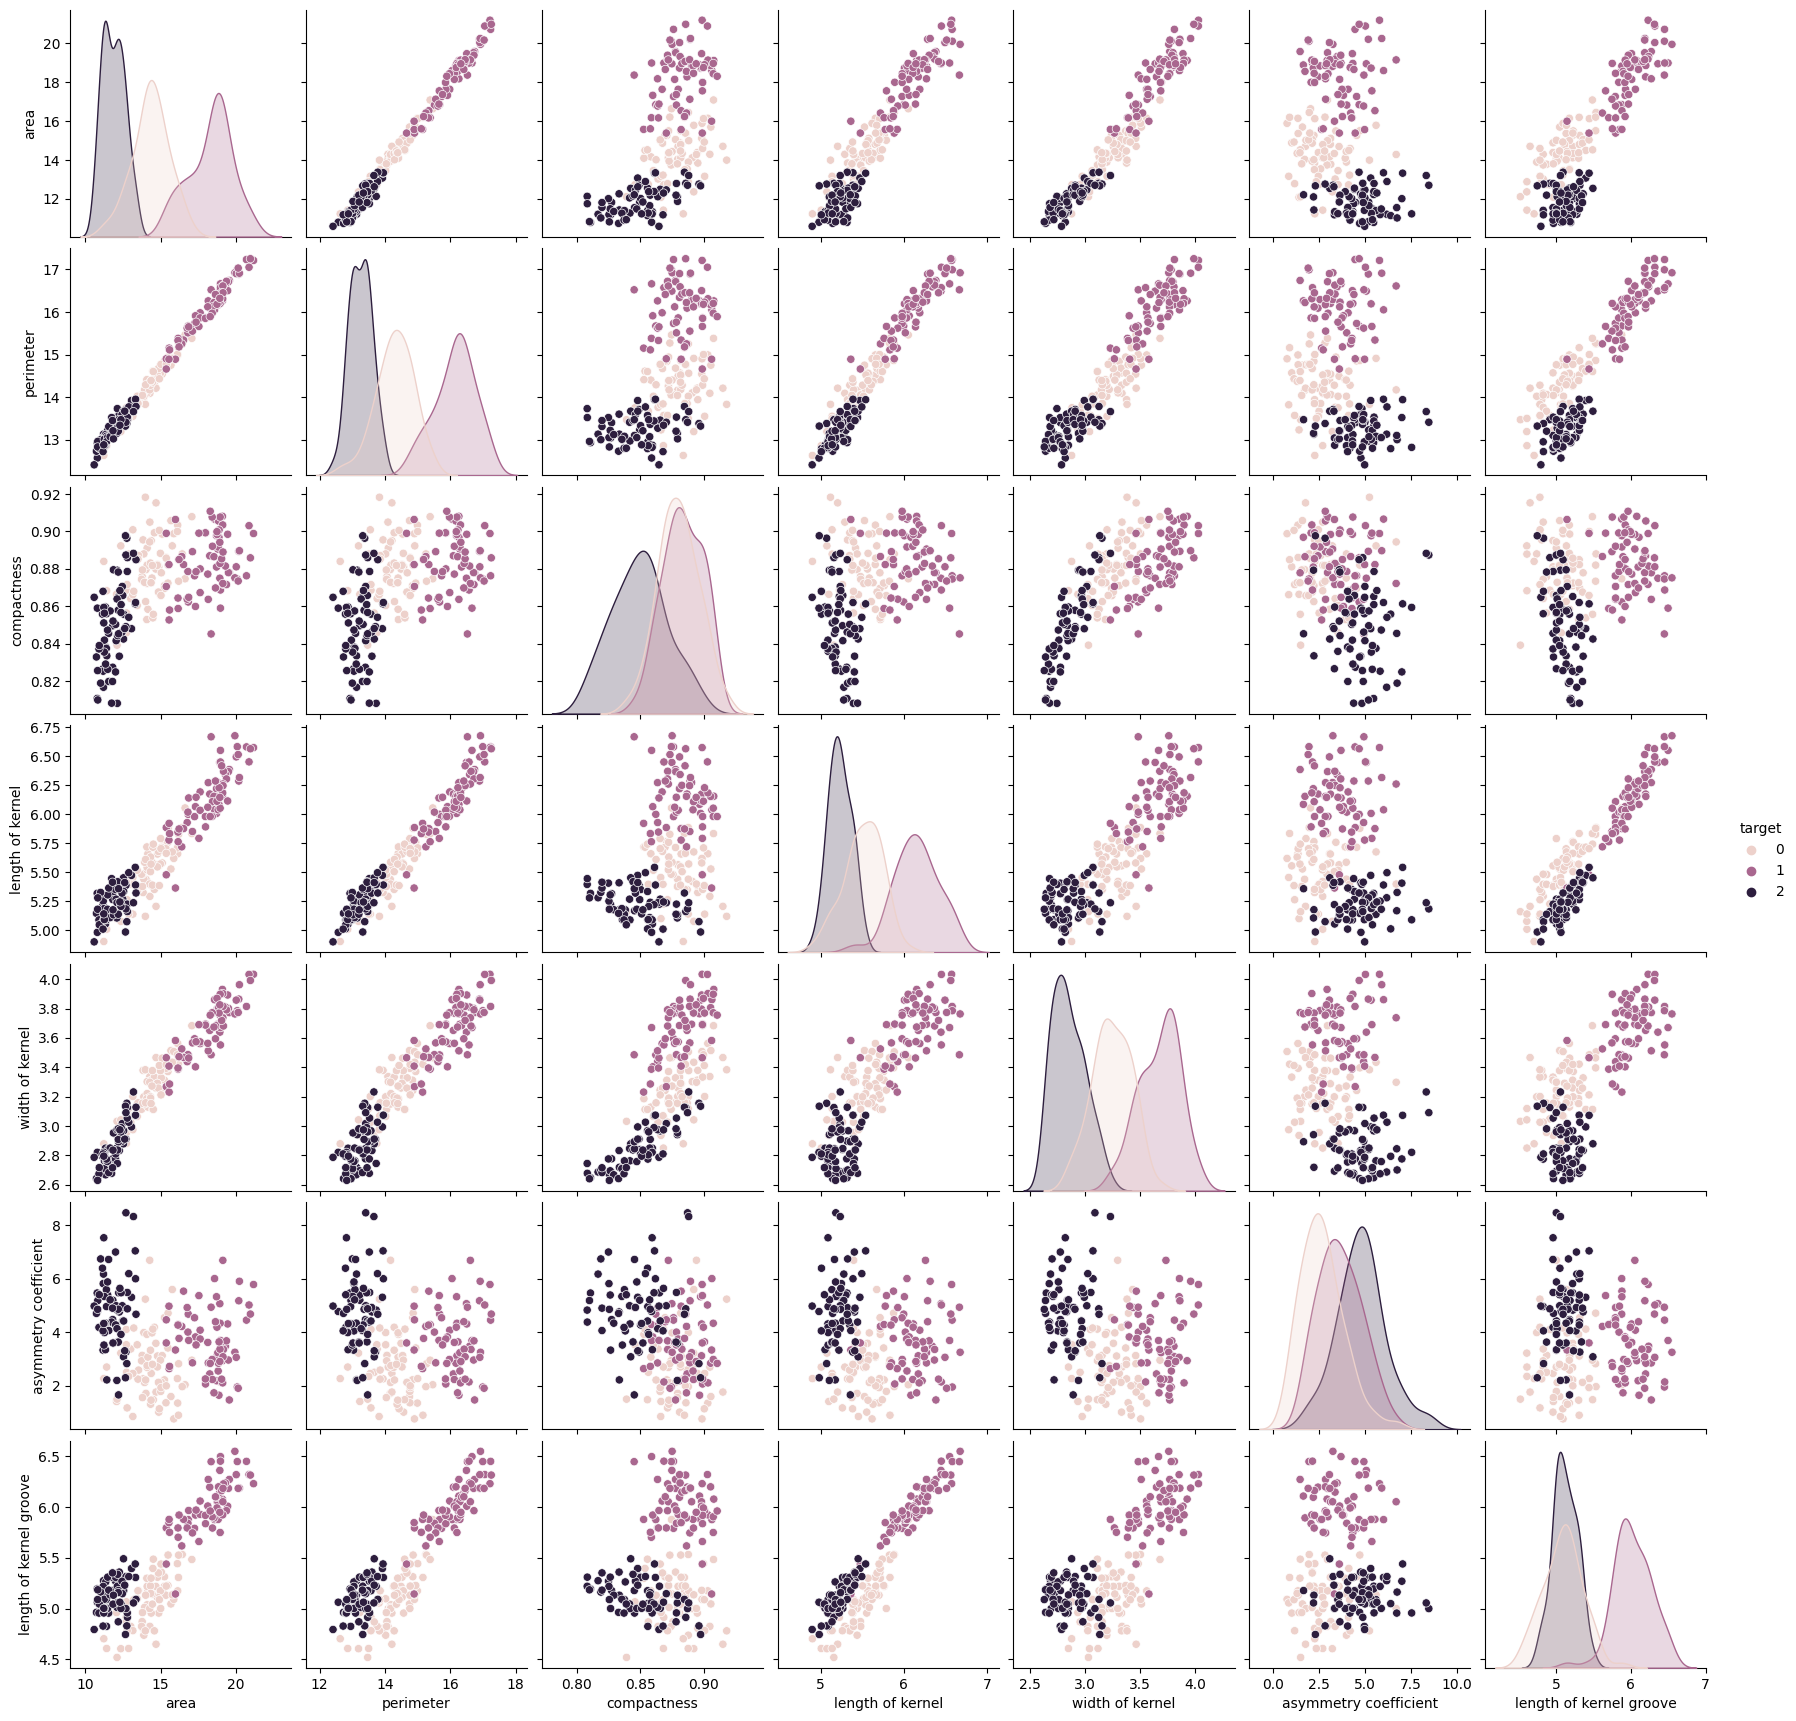

In [5]:
sns.pairplot(seed_data,hue="target")

### Seperate the input features from the target

In [6]:
cols = ["area", "perimeter", "compactness", "length of kernel", "width of kernel",
                 "asymmetry coefficient", "length of kernel groove"]
input_features = seed_data[cols]
target = seed_data["target"]

## Define the Gaussian Mixture model

In [7]:
import numpy as np

class GMM:
    def __init__(self, n_components=3, max_iter=100, tol=1e-6, random_state=None):
        """
        Initialize the Gaussian Mixture Model.

        Parameters:
        - n_components: Number of Gaussian components.
        - max_iter: Maximum number of EM iterations.
        - tol: Convergence threshold for log-likelihood.
        - random_state: Seed for random number generator.
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def _initialize_parameters(self, X):
        """
        Initialize the parameters: means, covariances, and weights.
        """
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Randomly select initial means from the data points
        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[indices]

        # Initialize all covariances to the sample covariance of the dataset
        self.covariances = np.array([np.cov(X, rowvar=False)] * self.n_components)

        # Initialize component weights uniformly
        self.weights = np.ones(self.n_components) / self.n_components

    def _gaussian(self, X, mean, cov):
        """
        Compute the multivariate Gaussian probability density function.

        Parameters:
        - X: Input data.
        - mean: Mean of the Gaussian.
        - cov: Covariance matrix of the Gaussian.
        """
        n = X.shape[1]  # Number of features
        diff = X - mean
        inv_cov = np.linalg.inv(cov)
        exponent = np.einsum('...k,kl,...l->...', diff, inv_cov, diff)
        denominator = np.sqrt((2 * np.pi) ** n * np.linalg.det(cov))
        return np.exp(-0.5 * exponent) / denominator

    def _e_step(self, X):
        """
        E-step: Calculate responsibilities using current parameters.
        """
        n_samples = X.shape[0]
        self.resp = np.zeros((n_samples, self.n_components))

        # Calculate weighted probabilities for each component
        for k in range(self.n_components):
            self.resp[:, k] = self.weights[k] * self._gaussian(X, self.means[k], self.covariances[k])

        # Normalize across components to get posterior probabilities
        self.resp /= self.resp.sum(axis=1, keepdims=True)

    def _m_step(self, X):
        """
        M-step: Update parameters using current responsibilities.
        """
        n_samples = X.shape[0]

        for k in range(self.n_components):
            resp_k = self.resp[:, k]
            total_resp = resp_k.sum()

            # Update weights
            self.weights[k] = total_resp / n_samples

            # Update means
            self.means[k] = (X * resp_k[:, np.newaxis]).sum(axis=0) / total_resp

            # Update covariances
            diff = X - self.means[k]
            weighted_diff = resp_k[:, np.newaxis] * diff
            self.covariances[k] = np.dot(weighted_diff.T, diff) / total_resp

    def fit(self, X):
        """
        Fit the GMM to the data using the EM algorithm.

        Parameters:
        - X: Input data array of shape (n_samples, n_features)
        """
        self._initialize_parameters(X)
        log_likelihood = None

        for _ in range(self.max_iter):
            self._e_step(X)
            self._m_step(X)

            # Compute log-likelihood
            ll = np.sum(np.log(np.sum([
                self.weights[k] * self._gaussian(X, self.means[k], self.covariances[k])
                for k in range(self.n_components)
            ], axis=0)))

            # Check convergence
            if log_likelihood is not None and np.abs(ll - log_likelihood) < self.tol:
                break
            log_likelihood = ll

    def predict(self, X):
        """
        Predict the component assignments for the input data.

        Parameters:
        - X: Input data.

        Returns:
        - Component labels (integers from 0 to n_components-1).
        """
        responsibilities = np.array([
            self.weights[k] * self._gaussian(X, self.means[k], self.covariances[k])
            for k in range(self.n_components)
        ]).T

        return np.argmax(responsibilities, axis=1)

    def predict_proba(self, X):
        """
        Predict the posterior probabilities (responsibilities) for each component.

        Parameters:
        - X: Input data.

        Returns:
        - Array of shape (n_samples, n_components) with responsibilities.
        """
        responsibilities = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * self._gaussian(X, self.means[k], self.covariances[k])

        # Normalize to get probabilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities


## Check the correlation between features using pearson correlation coefficients

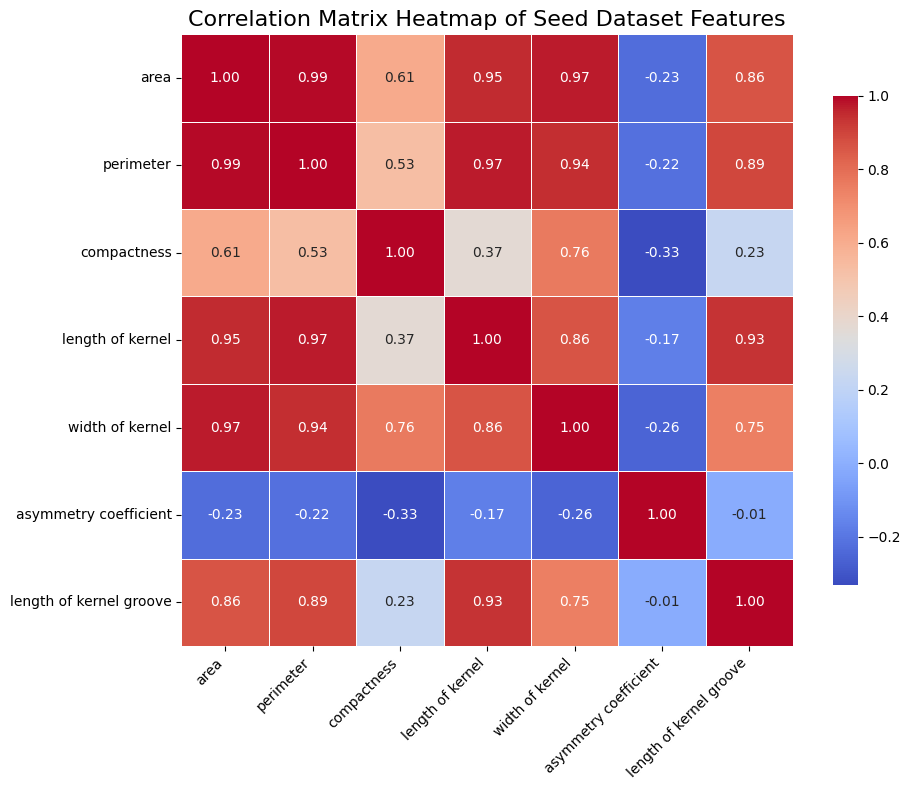

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Compute correlation matrix
corr_matrix = input_features.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix Heatmap of Seed Dataset Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Corr.png')
plt.show()


In [10]:
corr_matrix

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove
area,1.000000,0.994341,0.608288,0.949985,0.970771,-0.229572,0.863693
perimeter,0.994341,1.000000,0.529244,0.972422,0.944829,-0.217340,0.890784
compactness,0.608288,0.529244,1.000000,0.367915,0.761635,-0.331471,0.226825
length of kernel,0.949985,0.972422,0.367915,1.000000,0.860415,-0.171562,0.932806
width of kernel,0.970771,0.944829,0.761635,0.860415,1.000000,-0.258037,0.749131
asymmetry coefficient,-0.229572,-0.217340,-0.331471,-0.171562,-0.258037,1.000000,-0.011079
length of kernel groove,0.863693,0.890784,0.226825,0.932806,0.749131,-0.011079,1.000000


## Drop the features with absolute correlation coefficient greater than 0.8

In [11]:
abs_corr_matrix = corr_matrix.abs()
upper = abs_corr_matrix.where(np.triu(np.ones(abs_corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

dropped_input = input_features.drop(to_drop,axis=1)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [12]:
dropped_input

,area,compactness,asymmetry coefficient
0,15.26,0.8710,2.221
1,14.88,0.8811,1.018
2,14.29,0.9050,2.699
3,13.84,0.8955,2.259
4,16.14,0.9034,1.355
...,...,...,...
205,12.19,0.8783,3.631
206,11.23,0.8511,4.325
207,13.20,0.8883,8.315
208,11.84,0.8521,3.598


### Prepare the data for fitting

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = dropped_input.values
X_scaled = scaler.fit_transform(X)
y = target.values

### Fit the GMM on the data 

In [15]:
gmm = GMM(n_components=3, max_iter=100, tol=1e-4, random_state=42)
gmm.fit(X_scaled)
pred_labels = gmm.predict(X_scaled)

In [16]:
pred_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

## Visualizations

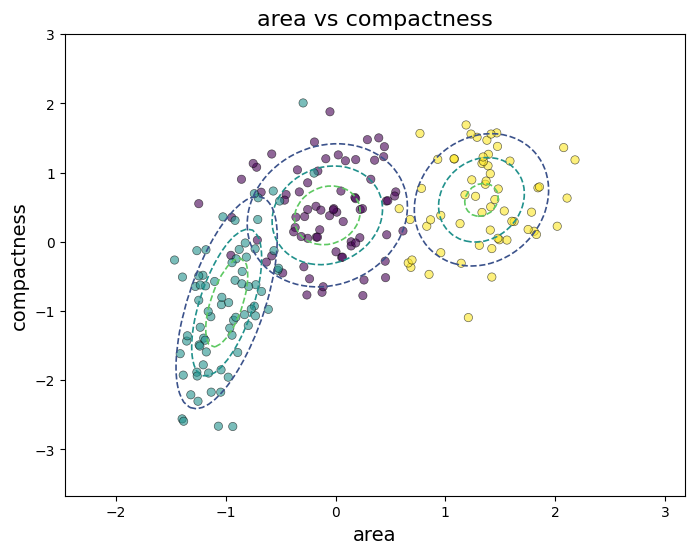

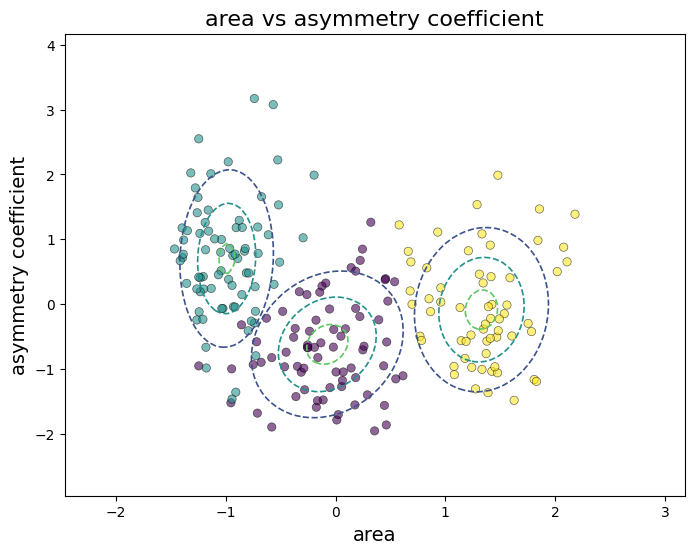

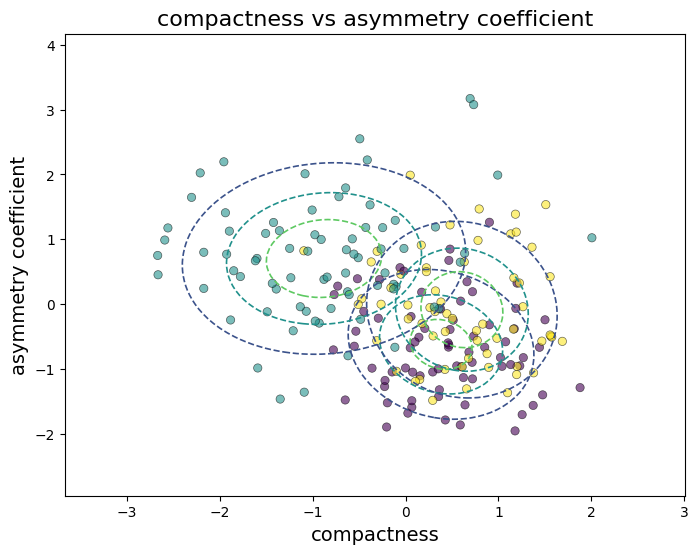

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.stats import multivariate_normal

# Assuming you have the following variables already:
# X_scaled (scaled features)
# feature_names (list of feature names)
# pred_labels (predicted labels from GMM)
# gmm (the trained GMM model)

# Create a DataFrame for the features and predicted labels

feature_names = dropped_input.columns.tolist()
X_df = pd.DataFrame(X_scaled, columns=feature_names)
X_df["Cluster"] = pred_labels

# Generate all unique pairs of features
feature_pairs = list(combinations(feature_names, 2))

# Loop through each pair of features
for i, (feat1, feat2) in enumerate(feature_pairs):
    # Create a new figure for each pair of features
    plt.figure(figsize=(8, 6))  # Set the size of the individual figure
    
    # Create scatter plot with seaborn
    sns.scatterplot(
        data=X_df,
        x=feat1,
        y=feat2,
        hue="Cluster",
        palette="viridis",
        edgecolor='k',
        alpha=0.6,
        legend=False
    )

    # Feature indices for meshgrid and GMM parameters
    idx1 = feature_names.index(feat1)
    idx2 = feature_names.index(feat2)

    # Meshgrid for contour
    x = np.linspace(X_df[feat1].min() - 1, X_df[feat1].max() + 1, 100)
    y = np.linspace(X_df[feat2].min() - 1, X_df[feat2].max() + 1, 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    pos = np.dstack((X_grid, Y_grid))

    # Plot Gaussian contours for each cluster
    for k in range(gmm.n_components):
        mean = [gmm.means[k][idx1], gmm.means[k][idx2]]
        cov = gmm.covariances[k][[idx1, idx2]][:, [idx1, idx2]]
        rv = multivariate_normal(mean, cov)
        plt.contour(X_grid, Y_grid, rv.pdf(pos), levels=3, linewidths=1.2, linestyles='dashed')

    # Set title and labels for each plot with increased font sizes
    plt.title(f"{feat1} vs {feat2}", fontsize=16)  # Increased font size for title
    plt.xlabel(feat1, fontsize=14)  # Increased font size for xlabel
    plt.ylabel(feat2, fontsize=14)  # Increased font size for ylabel
    plt.savefig(f"ellipses_{i}.png")
    # Show the plot
    plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


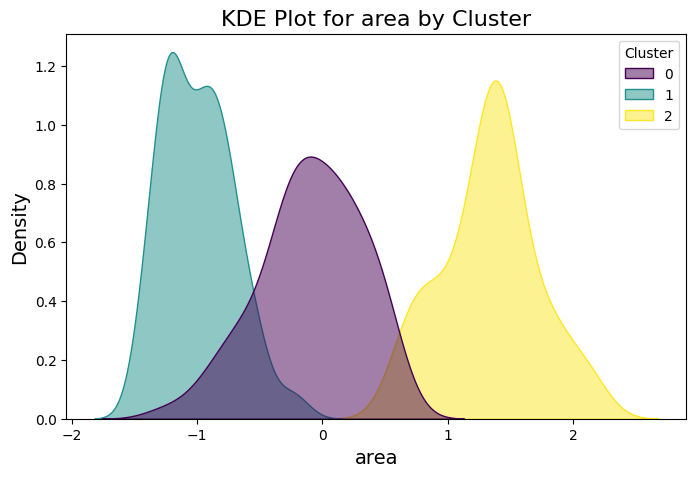

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


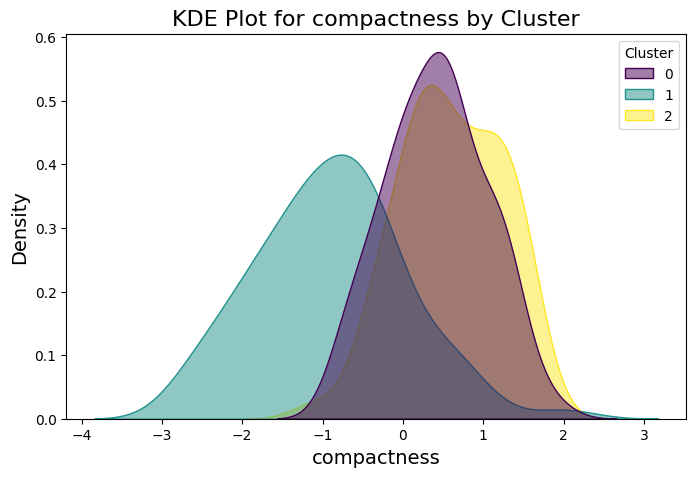

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


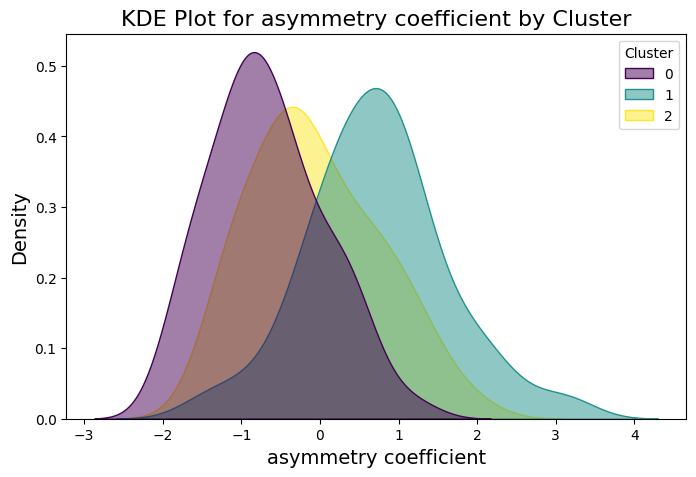

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through each feature
for feature in feature_names:
    plt.figure(figsize=(8, 5))
    
    # KDE plot grouped by cluster
    sns.kdeplot(
        data=X_df,
        x=feature,
        hue="Cluster",
        fill=True,
        common_norm=False,
        palette="viridis",
        alpha=0.5
    )

    # Title and axis labels
    plt.title(f"KDE Plot for {feature} by Cluster", fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel("Density", fontsize=14)

    # Save the plot (optional)
    plt.savefig(f"kde_{feature}.png")
    
    # Show the plot
    plt.show()


### Check the metrics for model performance

In [20]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import numpy as np
y = target.values

def match_labels(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Hungarian algorithm to find best label mapping
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize total matches
    
    # Map predicted labels to true labels
    mapping = dict(zip(col_ind, row_ind))
    matched_preds = np.array([mapping[label] for label in y_pred])
    
    return matched_preds, mapping

# Apply mapping
matched_preds, label_mapping = match_labels(y, pred_labels)

# Now you can compute metrics like accuracy
from sklearn.metrics import accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(y, matched_preds):.2f}")
from sklearn.metrics import classification_report
import pandas as pd

# Generate and convert to DataFrame
report_dict = classification_report(y, matched_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(2)

# Rename columns to classical terms
report_df.rename(columns={
    "precision": "Positive Predictive Value",        # Classical name for precision
    "recall": "True Positive Rate (Sensitivity)",    # Classical name for recall
    "f1-score": "F1 Score",                           # Standard name
    "support": "Support (Number of Samples)"         # More descriptive
}, inplace=True)


# Display the modified DataFrame
report_df



Accuracy: 0.90


,Positive Predictive Value,True Positive Rate (Sensitivity),F1 Score,Support (Number of Samples)
0,0.82,0.87,0.85,70.0
1,0.98,0.86,0.92,70.0
2,0.89,0.96,0.92,70.0
accuracy,0.90,0.90,0.90,0.9
macro avg,0.90,0.90,0.90,210.0
weighted avg,0.90,0.90,0.90,210.0


## Check the Means and Covariances

In [21]:
gmm.means

array([[-0.07512898,  0.38265766, -0.62166207],
       [-0.99189057, -0.87746631,  0.70271506],
       [ 1.3292832 ,  0.60688893, -0.08664065]])

In [22]:
gmm.covariances

array([[[ 0.20096515,  0.03499846,  0.05992444],
        [ 0.03499846,  0.40369324, -0.06404258],
        [ 0.05992444, -0.06404258,  0.53851572]],

       [[ 0.07957513,  0.16200001,  0.01533626],
        [ 0.16200001,  0.88299001,  0.05946234],
        [ 0.01533626,  0.05946234,  0.82758298]],

       [[ 0.15934764,  0.03675197,  0.02212441],
        [ 0.03675197,  0.38932468, -0.03554195],
        [ 0.02212441, -0.03554195,  0.68767726]]])